Overview
====
"Inatissentis sentere querum" is a Latin expression meaning, of course, nothing, because those aren't real Latin words. In fact, they are fake Latin words generated by training an algorithm on a Latin text. These words look to me, a non-Latin-knower, like realistic Latin words, and hopefully they do to you, too. Of course, if you know Latin, they probably look terrible, and you're probably already mad at me. Instead, take a look at some of the other languages that I've modeled!

This project explores using Markov chains to model word structure in an alphabet-based language, after being trained on a text in that language. This model is then used to generate realistic-looking fake words and to detect "foreign-looking" words.

What is a "word?"
----------------
There are a lot of ways to define a "word." For this project, I'll define a word to be a sequence of letters and certain approved punctuation marks. As far as approved punctuation, I have included the apostrophe in languages that use them for contractions. This means that a contraction like "don't" will be counted as "don't", rather than being counted as "dont" or as two separate words, "don" and "t."

For languages with accented letters, I've chosen to model accented letters as if each one were its own distinct letter. So, my French "alphabet" includes 'E,' 'É,' 'È,' 'Ê,' and 'Ë' as separate "letters." Confusingly, it is possible for a dictionary or text to contain letters that are not in the alphabet! For example, the letters 'J,' 'K,' 'W,' 'X,' and 'Y' are not considered to be part of the Italian alphabet, but they occur frequently in loan words. I use the '?' character to model all non-alphabet characters in each language.

Below are the alphabets that I've defined for each language.

In [1]:
# Just cruft. How does anyone survive without these?
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fake_words.fake_words import LANGUAGES

for language in LANGUAGES.values():
    print u"{}: {}".format(language.name, " ".join(list(language.alphabet)))

latin: a b c d e f g h i l m n o p q r s t u v w x z
german: a ä b c d e f g h i j k l m n o ö p q r s ß t u ü v w x y z
spanish: a á b c d e é f g h i í j k l m n ñ o ó p q r s t u ú ü v w x y z
french: a à â ä b c ç d e é è ê ë f g h i î ï j k l m n o ö ô p q r s t u û ü ù v w x y z '
english: a b c d e f g h i j k l m n o p q r s t u v w x y z '
polish: a ą b c ć d e ę f g h i l ł m n ń o ó p r s ś t u w y z ź ż
italian: a à b c d e è é f g h i ì l m n o ò p q r s t u ù v z '


Modeling with a Markov chain
===============
What constitutes a good fake word? "Mait" seems like a good fake French word to me, whereas "xkuq" does not seem like a good fake French word. How can we differentiate between these words?

There are a couple good clues in here. One important aspect is letter frequency. 'R,' 'A,' 'I,' and 'T' are all commmon letters in French, whereas 'X,' and 'K' are not. Another important thing is sequences of letters. The letter sequences "XK," "UQ," "XKU," and "KUQ" are all exceedingly uncommon. It's also realatively uncommon for a word to start with "X," or to end with "Q."

This can be used to create a simple language model wherein words with common sequences of letters are judged to be likely, and words with uncommon sequences are judged to be unlikely. I have chosen to use a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) to model the interactions between letters. Instead of modeling each letter individually, now each word is modeled as a sequence of states, where each state corresponds to a letter. This means that there is a parameter for the probability of each transition between any two states. These parameters can still be estimated from the training document. Note that this is just a vanilla discrete Markov chain where the states are the letters themselves; there is no hidden state.

Unigram model
------------
First, I have a letter frequency model that looks at each letter individually. For this, the likelihood of a word is the product of the likelihood of each letter in the word. This can be thought of a degenerate version of a Markov model, i.e. a [Markov chain of order 0](https://cw.fel.cvut.cz/wiki/_media/courses/a6m33bin/markov-chains-2.pdf).

For an *N*-letter alphabet, there are *N* parameters, which are estimated using maximum likelihood estimates from training documents.

Bigram model
-----------
For this model, I treat the word as a simple Markov chain where each state corresponds to a single letter. There is a parameter from the probability of transitioning from any given state to any other state. For an *N*-letter alphabet, there are now *N*² state transition parameters to learn. This will create a lot of cases where the parameters aren't covered by the training data. For example, *A Tale of Two Cities* doesn't contain the letter sequences "XZ", "ZX," or "VF," amongst many others. In order to prevent this from zeroing out the likelihoods, I've used [add-one smoothing](https://en.wikipedia.org/wiki/Additive_smoothing), adding one to any [bigram](https://en.wikipedia.org/wiki/Bigram) that doesnt appear in the training text. A slightly more principled way to do this would be to add a smoothing parameter *α*, instead of 1, to each count. This parameter *α* could be learned by doing cross-validation on another text. If I weren't too lazy to do it, that is.

I'm handling the starts and ends of words specially in order to make the model generate more realistic words. For example, the model should capture that it's extremely uncommon for an English word to end with the letter "Q." To do this, I added Markov chain states for start and end tokens. This idea is taken from computational linguistics, where it is common to put these tokens at the start and end of sentences when modeling sentence structure. These tokens behave more or less like letters, except that they must appear at the start and the end of each word, and they may not appear in the middle of the words. So, the word "in" is represented as, ```["start token", "I", "N", "end token"]```.

Trigram model
------------
For this model, I treat the word as a [Markov chain of order 2](https://cw.fel.cvut.cz/wiki/_media/courses/a6m33bin/markov-chains-2.pdf), where each state corresponds to a single letter, but it depends on the *two* previous states, not just the one previous state. This lets the model know about common and uncommon [trigrams](https://en.wikipedia.org/wiki/Trigram).

Final multiplicative model
------------------------
I'm using the two Markov models alongside the letter frequency model from the previous section. To calculate the proportional likelihood of a word this way, I take the likelihood of the word in each of the three models above. This results in a function that is not an actual likelihood, but is *proportional* to the likelihood, which works fine for what I'm trying to do. To get the actual likelihood, it would be necessary to divide this proportional likelihood by a very nasty constant.

Multiplying these three models together provides a smoothing effect that counteracts the sparsity of training data for the bigram and trigram parameters. For example, even if the training document didn't have any instances of the trigram, "ERN," we would still be able to see that its consitituent letters and bigrams are fairly common, so the sequence "ERN" would have a relatively high likelihood. This idea is stolen from [Eugene Charniak's](https://cs.brown.edu/~ec/) computational linguistics class.

Here's the training document for each language, and its length.

In [4]:
for language in LANGUAGES.values():
    print "{} training document: {}, {} characters".format(language.name, language.corpus_name, len(language.corpus))

latin training document: Cicero's Orations, 112249 characters
german training document: Siddhartha, 237229 characters
spanish training document: Belarmino y Apolonio, 450096 characters
french training document: Les Misérables, 692101 characters
english training document: A Tale of Two Cities, 792985 characters
polish training document: Pan Tadeusz, 240531 characters
italian training document: La vita italiana durante la rivoluzione francese e l'Impero, 67461 characters


In [5]:
# We're going up to trigrams
MAX_GRAM = 3

In [6]:
from fake_words.fake_words import Language

trigram_languages = [Language(info, 0, MAX_GRAM) for info in LANGUAGES.values()]

The code below prints out the highest-frequency n-grams in each language. Start and end tokens are shown with the ⋅ character. So, "e⋅", the most frequent English bigram, occurs when a word ends with the letter "E."

In [7]:
from operator import itemgetter

for language in trigram_languages:
    for n in range(1, MAX_GRAM+1):
        top_pairs = sorted(language.n_grams[n].iteritems(), key=itemgetter(1), reverse=True)[:10]
        top_n_grams = [u"".join(n_gram_tuple) for n_gram_tuple, count in top_pairs]
        top_n_grams_pretty = [n_gram.replace(u" ", u"⋅") for n_gram in top_n_grams]
        print u"top {}-grams in {}: {}".format(n, language.info.name, u", ".join(top_n_grams_pretty))
    print

top 1-grams in latin: ⋅, e, i, t, a, u, s, n, o, r
top 2-grams in latin: s⋅, m⋅, e⋅, t⋅, er, ⋅a, qu, is, ⋅i, ⋅c
top 3-grams in latin: um⋅, is⋅, ⋅qu, am⋅, ⋅in, us⋅, ⋅co, em⋅, ent, que

top 1-grams in german: ⋅, e, n, i, r, s, a, t, h, d
top 2-grams in german: n⋅, en, e⋅, er, r⋅, ch, ⋅d, ⋅s, t⋅, in
top 3-grams in german: en⋅, er⋅, ein, ich, nd⋅, ch⋅, ⋅de, und, te⋅, ⋅un

top 1-grams in spanish: ⋅, e, a, o, s, n, r, i, l, d
top 2-grams in spanish: a⋅, e⋅, o⋅, s⋅, ⋅e, ⋅d, n⋅, de, en, ⋅l
top 3-grams in spanish: ⋅de, de⋅, os⋅, ⋅la, ⋅co, la⋅, que, ⋅qu, as⋅, es⋅

top 1-grams in french: ⋅, e, a, i, t, s, n, r, u, l
top 2-grams in french: e⋅, t⋅, s⋅, ⋅d, ⋅l, ai, es, le, ⋅c, ⋅p
top 3-grams in french: es⋅, it⋅, ⋅de, le⋅, ait, de⋅, ⋅qu, nt⋅, ⋅le, re⋅

top 1-grams in english: ⋅, e, t, a, o, n, i, h, s, r
top 2-grams in english: e⋅, ⋅t, th, d⋅, he, ⋅a, s⋅, t⋅, ⋅h, in
top 3-grams in english: ⋅th, the, he⋅, nd⋅, ⋅an, ed⋅, and, er⋅, ng⋅, ⋅to

top 1-grams in polish: ⋅, a, i, e, o, z, ?, s, n, r
top 2-gram

Since a unigram is the same as a letter, the estimated unigram frequencies should match generally-accepted letter frequencies. The English letters with highest estimated frequencies are, in order, "ETAONI." This is close to the generally-accepted [list of most frequent English letters](https://en.wikipedia.org/wiki/Letter_frequency), "ETAOIN." The discrepancy may be because I'm using a slightly old text ([*A Tale of Two Cities*](http://www.gutenberg.org/files/98/98.txt)), or just because the text is too short. Overall, the letter frequency ordering looks good for most languages.

Below is a short method to print out the most likely words for each language, for each length of word. Since this model calculates word likelihood as a product of letter likelihoods, shorter words will tend to have higher likelihoods. In any language, the most likely word will be the empty string.

Since an *M*-letter alphabet can form $M^N$ words of length *N*, exploring the search space of all words is expensive when *N* is large. I have (slightly) optimized this search by pruning the search if the likelihood of the word I'm at is already lower than the likelihood of one of the top words that's already been found. I tried to create a heuristic pruning strategy, but it did not work well.  With my current search, though, I can only generate words of up to four letters in a sane amount of time.

In [8]:
MAX_WORD_LENGTH = 4

In [9]:
for language in trigram_languages:
    for word_length in range(1, MAX_WORD_LENGTH + 1):        
        top_words = language.top_words(word_length, 10)
        top_words_formatted = u", ".join(top_words)
        print u"{} length-{}: {}".format(language.info.name, word_length, top_words_formatted)
    print

latin length-1: a, e, m, s, c, o, d, t, l, f
latin length-2: es, re, se, et, is, in, te, de, ne, am
latin length-3: que, cum, tum, qui, con, rem, sum, dis, res, dem
latin length-4: quam, quis, atis, quae, etis, orum, inis, atum, esse, quem

german length-1: e, a, o, s, n, f, r, d, u, t
german length-2: er, in, de, en, ge, st, se, un, es, be
german length-3: den, der, gen, ein, sen, und, ben, hen, die, ber
german length-4: sein, inen, eine, sten, unde, wein, lein, dein, icht, sich

spanish length-1: a, y, o, e, s, n, r, u, l, d
spanish length-2: de, la, es, se, no, en, lo, el, do, co
spanish length-3: que, des, las, los, ela, con, cos, del, res, nos
spanish length-4: ente, ques, dela, ento, lara, dera, dese, enta, esta, este

french length-1: à, a, t, e, y, s, m, i, n, r
french length-2: de, le, re, et, ce, se, ne, es, la, me
french length-3: que, les, des, ent, une, res, tre, ces, ait, ses
french length-4: lait, mait, ille, sait, fait, ques, ente, elle, vait, dent

english length-1: a,

One strange fake word that I notice here is "st," in fake-German. This doesn't look like a good German word to me, because it does not have any vowels. Since the model never looks at the word as a whole, it has no way of "counting" the vowels, consonants, or any other category of letter to ensure that they are occuring in appropriate proportions. Adding in a counting mechanism can make the model a lot more difficult to perform computation on, because it means that every letter has a dependency on every other letter. If you add a vowel at the start of the word, you may need to remove a vowel somewhere else in the word.

Generating fake words, finally!
=================
A functional system to model word probabilities can be used for many different things. To start with, we can find fake words, which are sequences of letters that look realistic, but aren't found in a dictionary. I'll just repeat the previous exercise, but using a dictionary for each language to eliminate sequences of letters that are already real words.

For each language, I have found an online dictionary. There are some discrepancies in things such as how accents are treated, and what does or doesn't count as a word. Some of these things are unavoidable and language-specific, e.g. in German the "ß" character is used [only after short vowels](https://en.wikipedia.org/wiki/%C3%9F#Usage_in_the_reformed_orthography_of_1996) except in Switzerland, Lichtenstein, and Namibia, and you don't even want to know what the rules were before 1996.

In [17]:
from random import choice

for language in trigram_languages:
    some_words = u", ".join([choice(list(language.dictionary)) for _ in xrange(6)])
    print u"some {} words: {}".format(language.info.name, some_words)

some latin words: mordendorum, dissentbat, condignam, commortue, consputatu, impetras
some german words: politiker, masten, gestaltungs, höllisch, geschichtsbuch, clan
some spanish words: privanza, hiscal, festejador, tirte, antidotario, alabarda
some french words: gagions, trainas, renfilaient, sensibiliserez, desorienta, desincarnes
some english words: ergogenic, arrivers, balustrades, coxless, blousier, smuggling
some polish words: interliniujcież, silpasiastra, huckleberry'ego, niepiaskujący, benzole, żaru
some italian words: anellaccio, universalisti, fonda, sgargarizziamo, sciupinerebbe, parlamentarismi


In [11]:
from math import log

for language in trigram_languages:
    for word_length in range(2, MAX_WORD_LENGTH + 1):        
        top_words = language.top_words(word_length, 100)
        top_nonwords = [w for w in top_words if w not in language.dictionary]
        top_nonwords_formatted = u", ".join(top_nonwords[:12])
        print u"{} length-{}: {}".format(language.info.name, word_length, top_nonwords_formatted)
    print

latin length-2: am, us, ta, um, ae, le, to, ia, im, pe, di, co
latin length-3: con, dis, tem, int, ium, ine, ant, tes, tis, the, sem, ius
latin length-4: atis, atum, pere, sent, inum, inam, inte, pris, cont, ment, inem, tent

german length-2: ht, om, ot, nn, hn, rn, ln
german length-3: ine, ind, eit, har, ere, jen, ese, ert, eie, ane, fre, wit
german length-4: inen, unde, lein, icht, eind, dien, iner, dend, eren, aben, scht, esen

spanish length-2: es, co, sa, ma, mo, an, ra, po, ba, pa, da, or
spanish length-3: ela, cos, una, den, ino, men, eno, ena, pas, ado, tra, lla
spanish length-4: ques, dela, ento, lara, dera, esta, endo, cona, elas, quel, quen, ella

french length-2: pe, it, ge, st, is, el, ar, at, al, là, pa, er
french length-3: ent, res, tre, ant, ine, ele, ens, ple, ons, int, che, ous
french length-4: mait, ille, ques, vait, rent, dant, quit, dest, ette, cont, lant, quis

english length-2: th, se, st, le, ve, te, ge, ce, ot, mr, ch, ke
english length-3: whe, ing, ind, hed, i

The less familiar I am with a language, the better the fake words look.

Sampling words progressively
===============
What's the fun of making fake words if they can only be four letters long? Especially with German? As I mentioned above, the challenge is that the search space of *N*-letter words is too big when *N* > 4. With Latin's measly 23-letter alphabet, there are only six million possible five-letter words. French, though, with 50 total letters, allows 312 million five-letter words! So, instead of trying to cover the entire search space of long words, why not sample?

For my first sampler, I sample words progressively from left to right, beginning with the start token and sampling each successive letter conditioned on the letters to its left. It should then be possible to generate *N*-letter words by doing [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling), i.e. throwing away all samples that are not of length *N*. 

latin: t, in, es, to, te, or, in, dieni, his, des, in, fori, quis, tit, it, es, it, am, en, qui
german: er, ger, sie, ste, he, lan, ein, ich, ind, auch, nich, wein, an, er, und, gen, se, es, sie, ir
spanish: es, co, el, no, es, ra, es, en, a, enta, que, en, no, a, in, no, co, es, se, se
french: le, se, al, le, s, sa, il, ce, se, a, ne, le, le, ant, le, a, le, il, se, se
english: no, his, of, of, he, me, in, a, en, the, he, e, in, the, the, se, de, he, on, the
polish: nie, si, ły, pro, mi, i, cze, nie, nie, le, na, cza, po, wic, ro, wie, cza, ra, o, ci
italian: ro, e, in, i, a, di, in, ner, le, pro, la, e, la, e, la, a, a, e, a, re


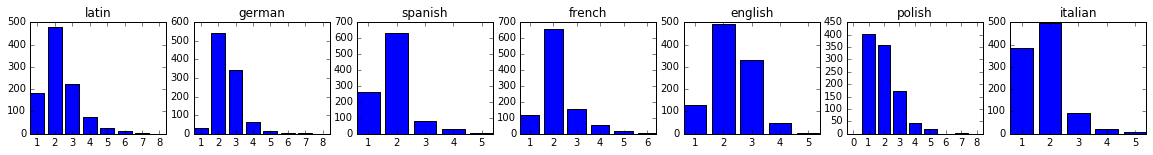

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(trigram_languages))
fig.set_figheight(2)
fig.set_figwidth(20)

for language, axis in zip(trigram_languages, axes):
    progressive_samples = language.sample_progressive(1000)
    word_lengths, counts = np.unique([len(word) for word in progressive_samples], return_counts=True)
    
    axis.set_xticks(word_lengths)
    axis.set_title(language.info.name)
    axis.bar(word_lengths, counts, align='center')
    
    print u"{}: {}".format(language.info.name, u", ".join(progressive_samples[:20]))

plt.show()

Unfortunately, this sampler is spending a lot of time generating short words, and also many repeated words. I suspect that the distribution of word length has an exponential tail. This means that generating long words with rejection sampling will be tragically inefficient.

Sampling words with MCMC
=============
How can we cover our sample space more effectively? This question always seems to have the same answer: [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). Note that the "Markov chain" in "Markov chain Monte Carlo" is a Markov chain where each state is a *sampled word,* and the chain is a series of samples. This is different than the Markov chain used to model word likelihood, which is a Markov chain where each state is a *letter,* and the chain of letters forms a word.

As such, I made a [Metropolis-Hastings sampler](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). I'm initializing each run with an *N*-letter word comprised of randomly uniformly chosen letters. The proposal distribution makes a 50/50 random choice between the following two options: it can replace a single letter of the previous sample with a randomly uniformly chosen letter, or it can swap two letters. Note that both of these moves keep the word at length *N*.

Below, the "sample" words represent samples, taken from the sampler at regular intervals (not sequentially, in order to reduce autocorrelation). They are presented in the order that they were sampled. The "top" words represent the highest-likelihood words that the sampler finds. They are presented with highest likelihood first. I restart the sampler from random initializations many times, in case it tends to get stuck in certain areas of the distribution.

In [13]:
from operator import itemgetter

for language in trigram_languages:
    for word_length in xrange(1, 13):
        samples, top = language.sample_mh(word_length, max_to_store=6, n_runs=100, n_samples_per_run=1000*word_length)

        samples_joined = u", ".join(word for word, prob in samples[:6])
        print u"{}-letter {} samples: {}".format(word_length, language.info.name, samples_joined)
        
        top_joined = ", ".join(word for prob, word in reversed(sorted(top, key=itemgetter(0))))
        print u"{}-letter {} top: {}\n".format(word_length, language.info.name, top_joined)
    print

1-letter latin samples: a, a, a, a, a, a
1-letter latin top: a, e, m, s, c, o

2-letter latin samples: se, es, se, at, es, me
2-letter latin top: es, re, se, et, is, in

3-letter latin samples: con, que, aes, his, ete, mum
3-letter latin top: que, cum, tum, qui, con, rem

4-letter latin samples: pere, quis, tera, idis, itur, orum
4-letter latin top: quam, quis, atis, quae, etis, orum

5-letter latin samples: tutam, milis, verum, terum, catis, potem
5-letter latin top: conis, quium, estis, intis, perum, intum

6-letter latin samples: inatum, gantas, ominem, pratis, ventem, coniss
6-letter latin top: querum, sentis, conium, inatis, sentum, queris

7-letter latin samples: licerit, eticaus, etistis, consect, ititant, leritam
7-letter latin top: interum, estatis, interis, peratis, sentere, sentiam

8-letter latin samples: conterit, destitam, estatule, ataticut, estiriam, quenitis
8-letter latin top: quitatis, essentis, senterum, essentum, intentis, senteris

9-letter latin samples: tulatqua

Encouragingly, the top-likelihood sampled words match the exhaustively-searched words well! Also encouragingly, the "top" words found by the sampler tend to be somewhat consistent between runs. These clues indicate that the sampler is probably not completely broken.

These words look pretty good. Once they get long, though, certain three-letter sequences of letters start to repeat (e.g. "dendendenden" in fake-German). This makes a lot of sense, since the model is only aware of the three-letter neighborhood next to each letter.

Using a sampling algorithm to search for high-likelihood points is a slight abuse of the sampler, since that's not what a sampler does. It works decently here, probably because the areas it's exploring aren't very large. To get better top-likelihood words, it would be best to use a real search algorithm.

Detecting foreign-looking words
=================
Time for some more fun! For this tangent, I'll go through the dictionary of each language to find words that seem to belong to other languages. Some of these are obviously loan words, but other ones (e.g. for Latin) just look foreign.

In order to get a ranking, I've simply taken the ratio of the likelihood in the destination languages to the likelihood in the source language. Note that this causes longer words to be chosen, which is ranking the words by a kind of *statistical significance*. A more Bayesian approach would entail dividing this ratio by word length, which would more closely measure *effect size*.

In [14]:
# Calculate the likelihood of each word in each language

from collections import defaultdict
from itertools import chain

all_words = set(chain(*(language.dictionary for language in trigram_languages)))

word_to_language_to_likelihood = defaultdict(dict)
for word in all_words:
    for language in trigram_languages:
        word_with_tokens = u" {} ".format(word)
        word_to_language_to_likelihood[word][language.info.name] = language.get_word_log_likelihood(word_with_tokens)

In [15]:
from operator import itemgetter

from fake_words.fake_words import try_to_store

N_TO_STORE = 5

# Loop over every pair of languages
for language_source in trigram_languages:
    for language_dest in trigram_languages:
        # A heap to store our best results
        best_words = []

        if language_dest is language_source:
            continue
    
        for word in language_source.dictionary:
            
            # Subtraction produces a ratio because these are log probabilities
            ratio = (word_to_language_to_likelihood[word][language_dest.info.name] - 
                     word_to_language_to_likelihood[word][language_source.info.name])
            try_to_store(best_words, word, ratio, N_TO_STORE)

        best_words_pretty = ", ".join(word for prob, word in reversed(sorted(best_words, key=itemgetter(0))))
        print u"{} words that look {}: {}".format(language_source.info.name, language_dest.info.name, best_words_pretty)
    print

latin words that look german: andrachnen, andrachlen, dendrachaten, pyrrhichen, jungebar
latin words that look spanish: decharmidabar, decharmidabas, apolactizabar, decharmidandos, decharmidando
latin words that look french: branchai, transfigurans, parochai, chondrillai, ravennai
latin words that look english: asty, branchad, spathad, chelyin, gry
latin words that look polish: chrysoprasie, onycha, sardonycha, zelotypo, chrysopastom
latin words that look italian: leopardale, leopardali, buttutti, chalaziai, leopardi

german words that look latin: simplicissimus, investitionsquote, computersimulation, quantitative, quantitativ
german words that look spanish: casablanca, violoncello, capriccio, carpaccio, colorado
german words that look french: journaille, croissants, croissant, quantitativ, montreux
german words that look english: heathrow, clooney, theatersaison, everybody, tomorrow
german words that look polish: psychosoziale, psychodrama, politologie, napoli, zbigniew
german words t

All right, now I'm having fun!

I always feel slightly offended when I see the words that look English. "Whiskey." "Sweepstake." "Branchad." "Spathad." "Overbooking!" Is this what English looks like to non-English-speakers? To make myself feel better, I imagine a heavy-set German man with a disproportionately large mustache saying, "braunschweiger," "breitschwanz," and "weltschmerzes" very seriously.

I also enjoy that the algorithm classifies "jeans" as French. Which is true, just ask any pair of Jeans.

Detecting distinctive words
===============
A similar application of this model is to detect distinctive-looking words, i.e. words that are likely in their source language but very unlikely in all other languages.

To model this, I'm ranking each word with the ratio between its likelihood in its source language to its likelihood in *any* other language. As above, since I'm not dividing by word length, this tends to select longer words.

Note that these distinctive-looking words are inherently relative to the other languages modeled. Adding another Germanic language, for example, might change the words that were reported as most distinctively German.

In [16]:
N_TO_STORE = 10

for language_source in trigram_languages:
    # A heap to store our best results
    best_words = []

    for word in language_source.dictionary:
        likelihood_source = word_to_language_to_likelihood[word][language_source.info.name]
        
        ratios = []
        for language_dest in trigram_languages:
            if language_dest is language_source:
                continue

            # Subtraction produces a ratio because these are log probabilities
            ratios.append(likelihood_source - word_to_language_to_likelihood[word][language_dest.info.name])
        
        try_to_store(best_words, word, min(ratios), N_TO_STORE)
                     
    best_words_pretty = ", ".join(word for prob, word in reversed(sorted(best_words, key=itemgetter(0))))
    print u"most {}-looking words: {}\n".format(language_source.info.name, best_words_pretty)

most latin-looking words: praeconsumpturorum, circumcumulaturorum, circummoeniturorum, circumequitaturorum, praeconsumpturum, praeconsumpturarum, curculiunculorum, praeconsumptorum, circumcumulaturum, circumcumulaturarum

most german-looking words: geschwindigkeitsbeschränkungen, weihnachtsgeschenken, verschleißerscheinungen, weihnachtsgeschichten, gleichgeschlechtlichen, zusammengehörigkeitsgefühl, sicherheitseinrichtungen, selbstverständlichkeiten, wahrscheinlichkeiten, geschwindigkeitsbeschränkung

most spanish-looking words: jerarquización, españolización, encuadernación, vulgarización, despoblación, despolarización, engrasación, señalización, despresurización, especialización

most french-looking words: bienfaiteurs, broussailleux, jouvenceaux, poursuivraient, bienfaiteur, souviendraient, malheureux, entrouvriraient, entrouvrirait, vouvoyaient

most english-looking words: knowledgeably, acknowledgedly, crookedly, thoughtlessly, heartbreakingly, greatheartedly, thoughtfully, overpo

"Geschwindigkeitsbeschränkung," WOOOO! That means "speed limit."

Conclusion
=====
Hopefully this article has illustrated the strengths and limitations of using a Markov model for word structure. It seems to work nicely for short words, but for long words it might need to be augmented by 4-grams or 5-grams, or it might need to be replaced by a more complex model.

This is a good start, but this is just the tip of the iceberg in terms of what could be done with a word structure model. Here are a couple ideas:
* Easily and automatically generate plausible wrong answers for multiple-choice spelling tests. This could be useful for language learning.
* Train the model on a fake language, and then sample words to create new words in that language.
* Generate a name for your startup (I believe that [Wordoid](http://wordoid.com/) may already be using a Markov model!).

There are also many NLP problems that could make use of word structure modeling: optical character recognition, speech recognition, swipe typing, spell checking, web search, and machine translation come to mind. I haven't found any examples of word structure modeling, perhaps because people communicate primarily using a vocabulary that can be easily stored in a dictionary. A word structure model could be useful to help to keep up with changing vocabularies, and to handle things such as names, which follow common structural patterns but are too numerous to fit into a dictionary.

Additional Reading
-----------------
I didn't do much research on the topic before writing this, so I'm probably ignorant of a lot of great work out there. If you know of something that does word structure modeling, please let me know!

* A [super fun paper](http://nl.ijs.si/janes/wp-content/uploads/2014/09/choudhuryothers07.pdf) from the Malaviya National Institute of Technology in Jaipur that uses a letter-level HMM to translate SMS abbreviations into their standard English equivalents.
* Peter Norvig wrote a [classic blog post](http://norvig.com/spell-correct.html) on how to write an extremely simple spelling correction algorithm.
* [Here](http://www.aclweb.org/anthology/N03-1018) is a paper on word structure modeling for OCR applications, by Kolak, Byrne, and Resnik.
* Andrej Karpathy wrote a [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) about using recurrent neural networks to do character-level language modeling.

Thanks
------
Thanks to [Eric Kernfeld](http://erickernfeld.yolasite.com/), Viktor Jakubiuk, Brandon Reiss, and Max Livingston for suggesting many improvements to this!